# Download the data
Data can be downloaded from https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation \
You can use the code below to download the data. First you need to download the API Token (kaggle.json) from the kaggle profile and place it in the current directory.


In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d faizalkarim/flood-area-segmentation

 76% 81.0M/107M [00:01<00:00, 68.8MB/s]
100% 107M/107M [00:01<00:00, 87.1MB/s] 


In [2]:
%%capture
!unzip flood-area-segmentation.zip

# Install & Import libraries

In [3]:
!pip install livelossplot kaggle tensorflow_addons -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from livelossplot.tf_keras import PlotLossesCallback

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Reading and preparation the data

Reading CSV with data. This CSV file contains the mapping of the image name to its mask.

In [5]:
img_path = './Image/'
mask_path = './Mask/'

df = pd.read_csv('./metadata.csv')
print(f'Number of Images: {df.shape[0]}')
df.head()

Number of Images: 290


,Image,Mask
0,0.jpg,0.png
1,1.jpg,1.png
2,2.jpg,2.png
3,3.jpg,3.png
4,4.jpg,4.png


In [6]:
df.Image = df.Image.apply(lambda file_name: img_path + file_name)
df.Mask = df.Mask.apply(lambda file_name: mask_path + file_name)
df.head()

,Image,Mask
0,./Image/0.jpg,./Mask/0.png
1,./Image/1.jpg,./Mask/1.png
2,./Image/2.jpg,./Mask/2.png
3,./Image/3.jpg,./Mask/3.png
4,./Image/4.jpg,./Mask/4.png


For some reason some images are not read correctly.This function overwrites them for future use.

In [7]:
def overwriting_broken_image(image_name:str) -> None:
    image = np.asarray(Image.open(image_name))
    if len(image.shape) < 3:
        print(f'{image_name} is the broken image')
        image = plt.imread(image_name) # Only plt.imread can read such an image. (I do not know why)
        plt.imsave(image_name, image)

for image in df.Image.values:
    overwriting_broken_image(image)

./Image/0.jpg is the broken image
./Image/3048.jpg is the broken image


Also, some images and masks don't match. It needs to be fixed

In [8]:
df.iloc[14, 1], df.iloc[15, 1] = df.iloc[15, 1], df.iloc[14, 1]
df.iloc[101, 1], df.iloc[102, 1] = df.iloc[102, 1], df.iloc[101, 1]

Let's look at some images

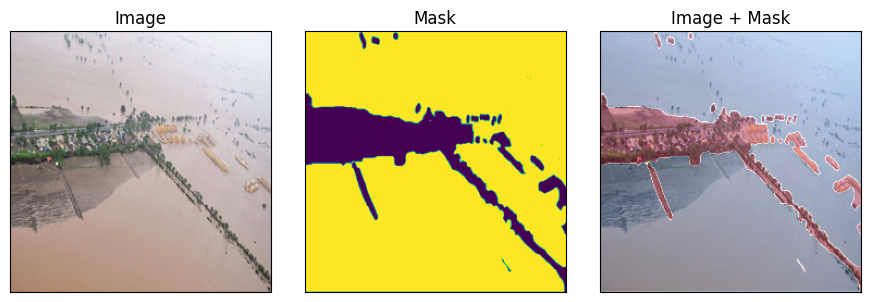

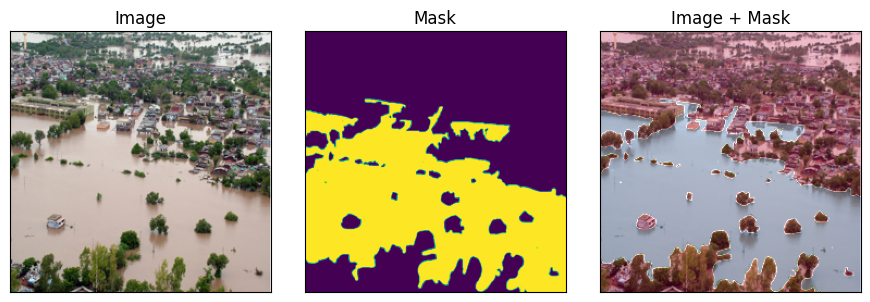

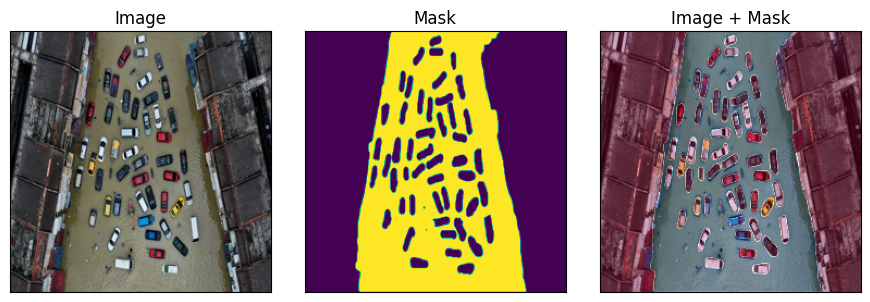

In [9]:
def show_random_examples() -> None:
    ncols=3
    nrows=1
    rand_indexes = np.random.choice(np.arange(df.shape[0]), 3)

    for index in rand_indexes:
        image = Image.open(df.Image.values[index]).resize((240, 240))
        image = np.array(image).astype(np.float32) / 255.
        mask = Image.open(df.Mask.values[index]).resize((240, 240))
        mask = np.array(mask).astype(np.float32) / 255.
        seg_mask = plt.get_cmap('RdBu')(mask)[..., :3]

        _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 3))

        ax[0].imshow(image)
        ax[1].imshow(mask)
        ax[2].imshow(np.clip(image*0.8 + seg_mask*0.5, 0, 1))

        ax[0].set_title('Image')
        ax[1].set_title('Mask')
        ax[2].set_title('Image + Mask')

        for i in range(ncols):
            ax[i].set_xticks([])
            ax[i].set_yticks([])

        plt.tight_layout()
        plt.show()

show_random_examples()

Validation split

In [10]:
def train_test_split(dataframe, train_size=0.9, shuffle=True, seed=17):
    np.random.seed(seed)
    size = dataframe.shape[0]
    indexes = np.arange(size)
    if shuffle:
        np.random.shuffle(indexes)

    limit = int(size * train_size)
    train = dataframe.iloc[indexes[:limit], :]
    test = dataframe.iloc[indexes[limit:], :]

    return train, test

In [13]:
train_df, val_df = train_test_split(df, 0.8)
val_df, test_df = train_test_split(val_df, 0.6)

In [15]:
train_df.shape, val_df.shape, test_df.shape

((232, 2), (34, 2), (24, 2))

# Creating the data generator class

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, image_paths:list, mask_paths:list, image_shape:list,
        batch_size:int, shuffle:bool=False, rescale:float=1.0,
        horizontal_flip:bool=False, vertical_flip:bool=False, rotation_range:float=0
        ):

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_shape = image_shape
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.rescale = rescale
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rotation_range = rotation_range

        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index:int):
        x = []
        y = []
        for i in (self.indexes[index * self.batch_size: (index+1) * self.batch_size]):
            image = self._load_image_file(self.image_paths[i], 'image')
            mask = self._load_image_file(self.mask_paths[i], 'mask')
            image = tf.image.resize(image, self.image_shape).numpy()
            mask = tf.image.resize(mask, self.image_shape).numpy()
            x.append(image)
            y.append(mask)

        x = np.asarray(x) * self.rescale
        y = np.asarray(y) * self.rescale

        if self.horizontal_flip:
            x, y = self._random_horizontal_flip(x, y)
        if self.vertical_flip:
            x, y = self._random_vertical_flip(x, y)
        if self.rotation_range:
            x, y = self._random_rotation(x, y, self.rotation_range)

        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    @staticmethod
    def _load_image_file(file_path:str, mode:str='image'):
        image = np.asarray(Image.open(file_path))
        if mode == 'image':
            image = image[:, :, :3]
        elif mode == 'mask':
            image = image[..., None]
        image = image.astype(np.float32)
        return image

    def _random_rotation(self, image, mask, rotation_range):
        angle = np.random.uniform(low=0, high=rotation_range)
        return (tfa.image.rotate(image, angle, fill_mode='nearest'),
                tfa.image.rotate(mask, angle, fill_mode='nearest'))

    def _random_horizontal_flip(self, image, mask):
        if np.random.randint(0, 2):
            return (tf.image.flip_up_down(image),
                    tf.image.flip_up_down(mask))
        else: return image, mask

    def _random_vertical_flip(self, image, mask):
        if np.random.randint(0, 2):
            return (tf.image.flip_left_right(image),
                    tf.image.flip_left_right(mask))
        else: return image, mask

# Prepare U-Net model
I use U-Net like architecture. The U-Net consists of an encoder for downsampling and a decoder for upsampling with skip connections.

In [17]:
IMAGE_SIZE = (768, 768)

def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size)

    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x


    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Build model
tf.keras.backend.clear_session()
model = get_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 384, 384, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 384, 384, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 384, 384, 32)         0         ['batch_normalization[0][0

# Training the model

In [18]:
BATCH_SIZE = 4

X_train = DataGenerator(
    train_df.Image.values,
    train_df.Mask.values,
    image_shape=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=2*np.pi

)

X_val = DataGenerator(
    val_df.Image.values,
    val_df.Mask.values,
    image_shape=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    rescale=1./255,
    horizontal_flip=False,
    vertical_flip=False
)

X_test = DataGenerator(
    test_df.Image.values,
    test_df.Mask.values,
    image_shape=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    rescale=1./255,
    horizontal_flip=False,
    vertical_flip=False
)

In [19]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

def mean_iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred - y_true * y_pred)
    return intersection / (union + K.epsilon())

def recall_score(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    TP = tf.reduce_sum(y_true * y_pred)
    FN = tf.reduce_sum(y_true * (1 - y_pred))

    recall = TP / (TP + FN + K.epsilon())
    return recall

def f1_score(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    TP = tf.reduce_sum(y_true * y_pred)
    FP = tf.reduce_sum((1 - y_true) * y_pred)
    FN = tf.reduce_sum(y_true * (1 - y_pred))

    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

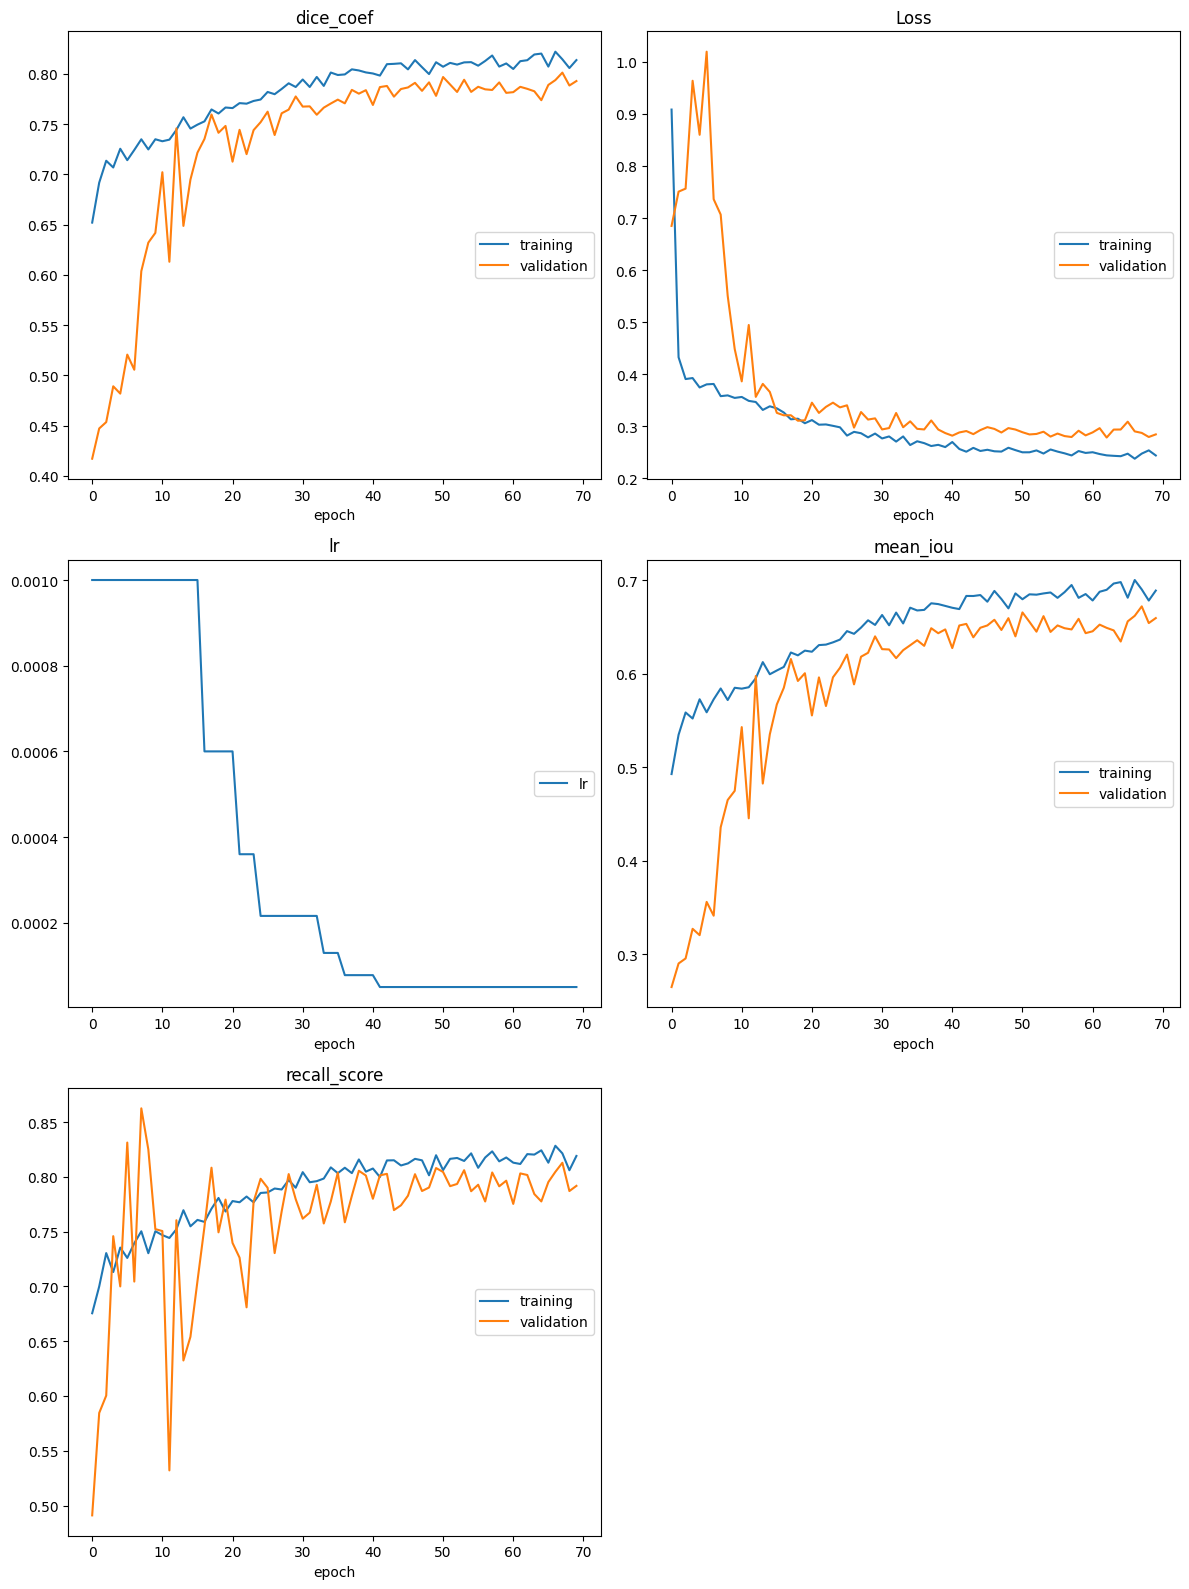

dice_coef
	training         	 (min:    0.652, max:    0.822, cur:    0.814)
	validation       	 (min:    0.417, max:    0.801, cur:    0.793)
Loss
	training         	 (min:    0.238, max:    0.908, cur:    0.244)
	validation       	 (min:    0.278, max:    1.020, cur:    0.284)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
mean_iou
	training         	 (min:    0.493, max:    0.700, cur:    0.689)
	validation       	 (min:    0.265, max:    0.672, cur:    0.659)
recall_score
	training         	 (min:    0.676, max:    0.828, cur:    0.819)
	validation       	 (min:    0.491, max:    0.863, cur:    0.792)
58/58 [==============================] - 41s 706ms/step - loss: 0.2439 - dice_coef: 0.8138 - mean_iou: 0.6887 - recall_score: 0.8191 - val_loss: 0.2844 - val_dice_coef: 0.7929 - val_mean_iou: 0.6593 - val_recall_score: 0.7918 - lr: 5.0000e-05


In [21]:
EPOCHS = 70
save_path = './models/'
model = get_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)

loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    save_path + 'best.h5',
    monitor='val_dice_coef',
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.6,
    patience=3,
    mode='max',
    min_lr=5e-5
)

loss_plot = PlotLossesCallback()
callbacks = [checkpoint, reduce_lr, loss_plot]
metrics = [dice_coef, mean_iou, recall_score]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(
    X_train,
    validation_data=X_val,
    verbose=1,
    callbacks=callbacks,
    epochs=EPOCHS
)

In [ ]:
model = tf.keras.models.load_model(
    filepath='./models/best.h5',
    custom_objects={
        'dice_coef': dice_coef,
        'mean_iou': mean_iou,
        'recall_score': recall_score
    }
)

In [24]:
val_loss, val_dice_coef, val_iou, val_recall = model.evaluate(X_val, verbose=0)
print(f'Val loss: {val_loss}\nVal dice coefficient: {val_dice_coef}')
print(f'Val IoU: {val_iou}\nVal recall: {val_recall}')

Val loss: 0.28727197647094727
Val dice coefficient: 0.8012843728065491
Val IoU: 0.6718449592590332
Val recall: 0.8128587603569031


In [26]:
test_loss, test_dice_coef, test_iou, test_recall = model.evaluate(X_test, verbose=0)
print(f'Test loss: {test_loss}\nTest dice coefficient: {test_dice_coef}')
print(f'\nTest IoU: {test_iou}\nTest recall: {test_recall}')

Test loss: 0.23622001707553864
Test dice coefficient: 0.7998840808868408
Test IoU: 0.6700303554534912
Test recall: 0.8339830040931702



The segmentation model was trained on a small dataset, consisting of fewer than 300 images. Despite the limited amount of data, the model achieved good results on the validation set:

+ Validation loss was 0.2872, indicating the model's ability to accurately reconstruct segmentation on images.

+ The Dice coefficient reached 0.8013, signifying a high degree of overlap between true and predicted segments. This metric is crucial in segmentation tasks.

+ The Intersection over Union (IoU) metric reached a value of 0.6718, also demonstrating the quality of the segmentation. IoU measures the extent of overlap between true and predicted segments.

+ The recall score was 0.8129, indicating the model's ability to detect objects within segmented regions with high completeness.

These results highlight the success of training the model with limited data and its capacity to accurately segment objects in images. Further improvements could be achieved by utilizing a larger dataset and potentially a more complex and deep model architecture.


# Visualize predictions

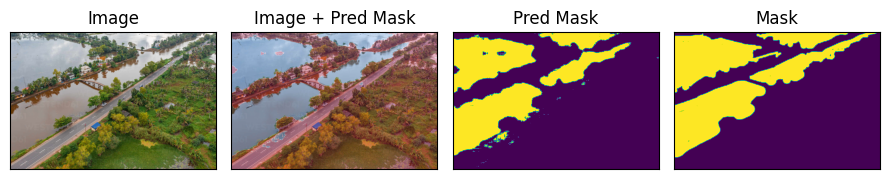

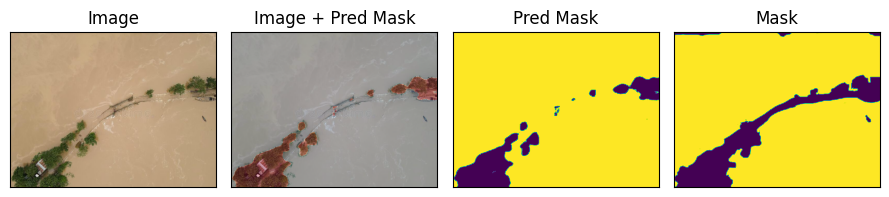

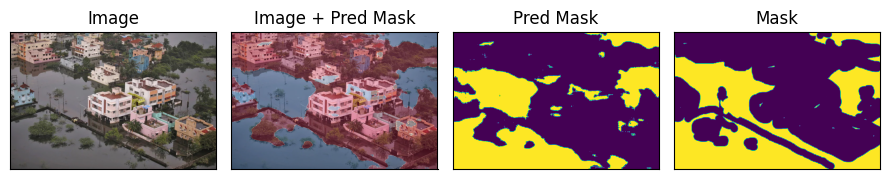

In [28]:
def show_prediction(image_path, mask_path=None):
    base_image = np.asarray(Image.open(image_path)).astype(np.float32) / 255.

    image = tf.image.resize(base_image, IMAGE_SIZE).numpy()

    prediction = model.predict(image[None, ...], verbose=0)[0, ...]
    prediction = np.array(prediction > 0.5).astype(np.int8)
    prediction = tf.image.resize(prediction, base_image.shape[:2]).numpy()[..., 0]
    seg_mask = plt.get_cmap('RdBu')(prediction)[..., :3]

    if mask_path:
        mask = np.asarray(Image.open(mask_path))[..., None].astype(np.float32) / 255.
        ncols = 4
    else:
        ncols = 3

    _, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(9, 3))

    ax[0].imshow(base_image)
    ax[1].imshow(np.clip(base_image*0.8 + seg_mask*0.5, 0, 1))
    ax[2].imshow(prediction)

    ax[0].set_title('Image')
    ax[1].set_title('Image + Pred Mask')
    ax[2].set_title('Pred Mask')

    if mask_path:
        ax[3].imshow(mask)
        ax[3].set_title('Mask')

    for i in range(ncols):
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.tight_layout()
    plt.show()

for i in np.random.choice(np.arange(test_df.shape[0]), 3):
    show_prediction(test_df.iloc[i].Image, test_df.iloc[i].Mask)